# Demo of Blip2 Quantization, Inference, and Scoring

## 1. Load Model and Quantize

In [1]:
from blip_quantizer import BlipQuantizer, QuantConfig, ModelPart, LayerGroup, LayerType
from quant_functions import uniform_quantization
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoTokenizer
from datasets import VQAv2Eval
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from utils import print_model_structure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")
model = model.to(device)

quantizer = BlipQuantizer(model)
configs = [
    QuantConfig(ModelPart.VIT, LayerGroup.FIRST, LayerType.BOTH, 
                uniform_quantization, num_bits=8),
    QuantConfig(ModelPart.VIT, LayerGroup.MIDDLE, LayerType.MLP, 
                uniform_quantization, num_bits=8),
    QuantConfig(ModelPart.QFORMER, LayerGroup.MIDDLE, LayerType.MLP, 
                uniform_quantization, num_bits=4),
]


print("Quantizing model...")
quantizer.apply_quantization(configs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantizing model...


In [3]:
from inference_pipeline import InferencePipeline

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
vqav2_dataset = VQAv2Eval(
    image_root="./data/vqav2/val2014",
    ann_root="./data/vqav2/annotations",
    q_root="./data/vqav2/questions"
)

inferencer = InferencePipeline(model, device, processor)
print("Starting inference...")
results = inferencer.run_inference(vqav2_dataset, task="visual_question_answering", max_samples=100, generate_kwargs={"max_length": 32})
print("Inference Finished, Saving Results...")
inferencer.save_results(results, "./results/vqav2_quantized_inference.json")

Starting inference...


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]

Inference Finished, Saving Results...


## 3. Score Results from .json File

In [4]:
from scoring_pipeline import ScoringPipeline

scorer = ScoringPipeline()
loaded_results = scorer.load_results("./results/vqav2_quantized_inference.json")
scores = scorer.compute_scores(loaded_results, task="visual_question_answering")

for metric, score in scores.items():
    print(f"{metric}: {score}")

Adding current path to python system paths
creating index...
index created!
Loading and preparing results...     
DONE (t=0.00s)
creating index...
index created!
computing accuracy
Finshed Percent: [--------------------] 0% Done computing accuracy
agg_metrics: 32.3
other: 21.16
yes/no: 44.0
number: 32.94


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Sample Results

This is not a necessary step but just helps qualitatively understand how the results relate to the answers.

In [5]:
import json
import matplotlib.pyplot as plt

f = open("./results/vqav2_quantized_inference.json")

data = json.load(f)
f.close()

def show_results(idx, results, vqav2_dataset):
    pair = vqav2_dataset.qa_pairs[idx]
    image = Image.open(vqav2_dataset.image_root+'/'+pair["image"]).convert("RGB")
    plt.figure()
    plt.imshow(image)
    plt.show()
    print(pair['question'])
    print(f"true answers: {pair['answer']}")

    pred_ans = []
    for qa in results["answers"]:
        if qa["question_id"] == pair["question_id"]:
            pred_ans.append(qa["answer"])
                            
    print(f"pred answers: {pred_ans}")

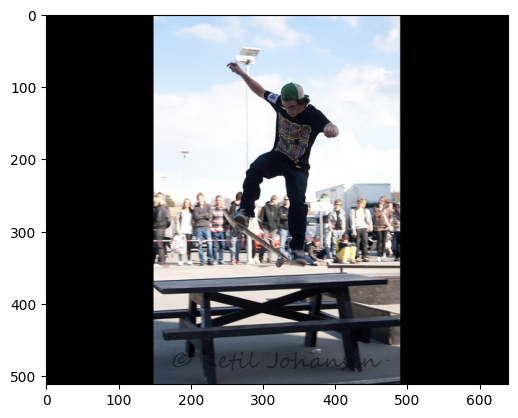

Question: Where is he looking? Short answer:
true answers: ['down', 'down', 'at table', 'skateboard', 'down', 'table', 'down', 'down', 'down', 'down']
pred answers: [" He's looking at the crowd\n"]


In [6]:
show_results(0, data, vqav2_dataset)

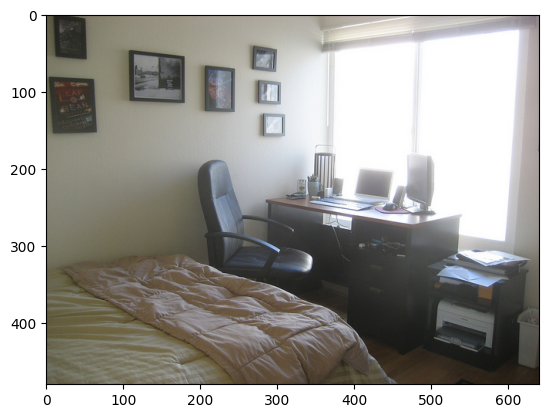

Question: What color is the bedspread? Short answer:
true answers: ['beige', 'white', 'pink', 'white', 'white', 'white', 'yellow', 'yellow', 'beige', 'yellow']
pred answers: [" it's black\n"]


In [7]:
show_results(20, data, vqav2_dataset)

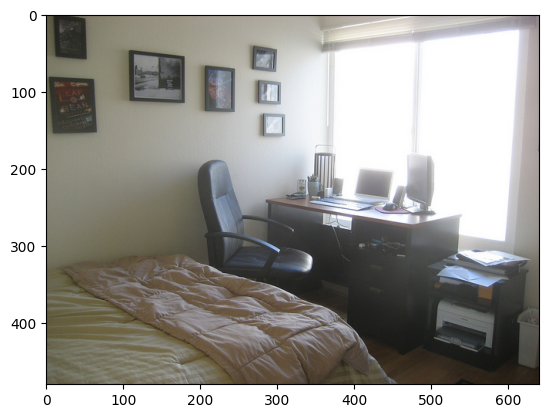

Question: How many frames are on the wall? Short answer:
true answers: ['7', '7', '7', '7', '7', '7', '7', '7', '7', '7']
pred answers: [' none\n']


In [8]:
show_results(40, data, vqav2_dataset)

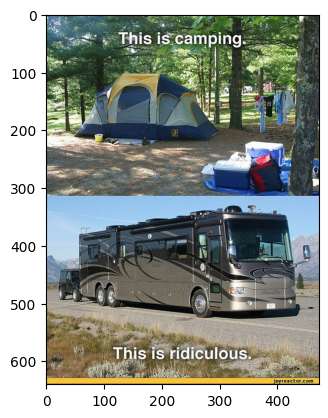

Question: What kind of vehicle is the RV pulling on the bottom picture? Short answer:
true answers: ['jeep', 'bus', 'jeep', 'brown', 'suv', 'suv', 'car', 'jeep', 'jeep', 'jeep']
pred answers: [' a motor home\n']


In [9]:
show_results(60, data, vqav2_dataset)

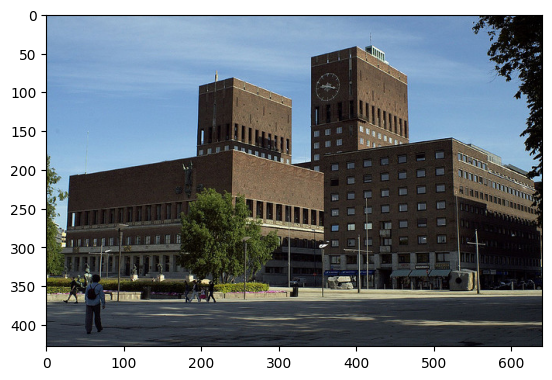

Question: Is there a tree in front of the building? Short answer:
true answers: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
pred answers: [' Yes\n']


In [10]:
show_results(80, data, vqav2_dataset)